<a href="https://colab.research.google.com/github/noahspenser/quantumcomputing/blob/master/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 1: Fourier and Cyclic Shift Matrices

In [1]:
import numpy, numpy.random, scipy, scipy.linalg
import matplotlib.pyplot as plt

# Setting tolerance for comparisons, set very low so that higher exponents can
# be tested -- works at the default 1e-05 up until around an N=10 Fourier matrix
tolerance = 1e-05

# Default values for easier usage of i and i to any power
i = 1j
iN = lambda N: i**N

# Copied functions from Homework 1, but adjusted to be approximate
# function to determine if a set of roots annihilate a matrix
def test_poly(inM, roots):
  # initialize output matrix
  outM = numpy.matrix(numpy.empty(inM.shape))

  first = True #to run first time only
  for root in roots:

    # on first run, initialize values to first multiple
    if(first): 
      outM = numpy.matrix(inM - root * numpy.matrix(numpy.identity(inM.shape[0])))
      first = False
    
    # all other runs, multiply current value by next multiple
    else: 
      outM = outM * numpy.matrix(inM - root * numpy.matrix(numpy.identity(inM.shape[0])))
  
  # if array is zero, then roots annihilate; otherwise they do not
  if(numpy.allclose(outM, numpy.matrix(numpy.zeros(inM.shape)), tolerance, tolerance/100)):
    return True 
  else:
    return False

# Function to calculate if a value is within tolerance to a value in an array
def almostIn(value, array):
  for val in array:
    if(abs(value-val)<tolerance):
       return True
  return False

# Abridged homework 1 function to return the unique roots of a matrix
def unique_roots(inM): 
  # calculate shape of input Matrix
  n, m = inM.shape
  
  # ensure input Matrix is square
  if n!=m: 
    print("Non-square matrix input, exiting")
    return #return if not
  
  # find coefficients of characteristic polynomial
  coeffs = numpy.poly(inM) 
  
  # find the roots of the characteristic polynomial
  roots = numpy.roots(coeffs)
  #for root in range(len(roots)):
    #roots[root] = round(roots[root]) #round the roots, as numpy is approximate
  if(not test_poly(inM, roots)): #validate roots
    print("Roots didn't annihilate matrix, exiting")
    return

  # find the unique roots and the number of each present in the characteristic polynomial
  uniqueroots = [] # initialize unique root list
  for root in roots: # calculate unique roots of characteristic polynomial
    if(not almostIn(root,uniqueroots)):
      uniqueroots.append(root) #append new roots to list
  # return unique roots
  return uniqueroots

# Confirm that a matrix is unitary
def ConfirmUnitary(inMat):
  # calculate shape of input Matrix
  l, w = inMat.shape

  # ensure input Matrix is square
  if(l != w):
    print("Trying to confirm if a non-square matrix is unitary, exiting.")
    return False
  
  # get identity matrix with same shape as input
  id = numpy.eye(l)

  # check if the matrix is within tolerance values to the identity and return
  return numpy.allclose(inMat * numpy.asmatrix(inMat).H, id, tolerance, 
                        tolerance/100)

# Calculate fourier matrix of size N
def get_fourier_matrix(N):
  # Calculate w value for size N
  w = numpy.exp(2.*numpy.pi*i/N)

  # Get index matrixes for ease of calculation
  grid = numpy.indices((N,N))

  # Calculate exponents by multiplying indices element-wise
  ex = numpy.multiply(grid[0], grid[1])

  # Calculate fourier matrix and return
  return (1/numpy.sqrt(N))*numpy.power(numpy.full((N, N),w), ex)

# Function to check if the eigenvalues are correct -- note there are probably
# better ways to do this (ensuring that all of the values are close to one of
# the 4 valid ones, etc... but this does work for our purposes)
def fourier_eigenvalue_test(M):
  # Sort input matrix
  srt = numpy.sort(unique_roots(M))
  
  # Prepare possible eigenvalue sets to compare against
  inarrs = numpy.array([[-1, -i, i, 1],[-1, i, -i, 1], [-1, 1], [-1, i, 1], [-1, -i, 1]])
  # and iterate through them to check if we match any of them
  for arr in inarrs:
    # Need to try except as allclose throws an exception on mismatched shapes
    try:
      cc = numpy.allclose(srt, arr, tolerance, tolerance/100)
      if(cc):
        return True
    # Obviously using try except blocks for handling is bad but it is the
    # simplest way to make this work here
    except:
      continue
  return False

def cyclic_eigenvalue_test(M, N):
  # Sort input matrix
  rts = unique_roots(M)

  # Calculate Nth roots of unity
  nroots = numpy.empty(N,dtype=complex)
  for k in range(N):
    nroots[k] = numpy.exp((2*numpy.pi*i*k)/N)
  # Ensure all roots are in the root of unity set
  for rt in rts:
    if(not almostIn(rt, nroots)):
      print("Root not in N unity root set, returning")
      return False
  return True

# Function to check if Fourier matrix matches requirements (within tolerance)
def test_fourier_matrix(M):
  # Calculate shape of input Matrix
  l, w = M.shape

  # ensure input Matrix is square
  if(l != w):
    print("Testing non-square fourier matrix, exiting.")
    return False

  # Ensure Fourier matrix is unitary
  if(not ConfirmUnitary(M)):
    print("Not Unitary")
    return False

  # Ensure Fourier matrix to the fourth power is identity
  if(not numpy.allclose(numpy.linalg.matrix_power(M, 4), numpy.eye(l), tolerance, tolerance/100)):
    print("F**4 != Identity")
    print(numpy.linalg.matrix_power(M, 4))
    return False

  # Ensure Fourier matrix eigenvalues are what they should be
  if(not fourier_eigenvalue_test(M)):
    print("Incorrect eigenvalues")
    return False
  # If we've made it here, success! It is the valid Fourier matrix
  return True

def get_cyclic_shift_matrix(N):
  # Get index matrixes for ease of calculation
  grid = numpy.indices((N,N))

  # Calculate first side of equation
  val = numpy.copy(grid[0])
  val = val + 1
  val = numpy.remainder(val, N)
  # Second side is just the other index
  val2 = grid[1]
  # Return the cyclic shift matrix
  return numpy.equal(val, val2).astype(int)

def test_cyclic_shift_matrix(M, F):
  # Calculate shape of input Matrix
  l, w = M.shape

  # ensure input Matrix is square
  if(l != w):
    print("Testing non-square fourier matrix, exiting.")
    return False

  # Ensure cyclic shift matrix is unitary
  if(not ConfirmUnitary(M)):
    print("Not Unitary")
    return False

  # Ensure cyclic shift matrix to the nth power is identity
  if(not numpy.allclose(numpy.linalg.matrix_power(M, l), numpy.eye(l), tolerance, tolerance/100)):
    print("F**N != Identity")
    print(numpy.linalg.matrix_power(M, l))
    return False

  # Ensure Fourier matrix eigenvalues are what they should be
  if(not cyclic_eigenvalue_test(M, l)):
    print("Incorrect eigenvalues")
    return False

  # Ensure it is diagonalized by Fourier matrix
  testarr = numpy.dot(numpy.dot(numpy.asarray(numpy.asmatrix(F).H), M),F)
  # Test for diagonality within tolerance
  if (not numpy.allclose(numpy.diag(numpy.diag(testarr)), testarr, tolerance, tolerance/100)):
    print("Not diagonalized by Fourier matrix")
    return False

  # If we've made it here, success! It is the valid Fourier matrix
  return True

# Main function to show success
def main():
  print("Current tolerance value: " + str(tolerance))
  print("\nFourier matrix for N = 3:")
  fm = get_fourier_matrix(3)
  print(fm)
  print("Cyclic shift matrix for N = 3:")
  cm = get_cyclic_shift_matrix(3)
  print(cm)
  print("Testing Fourier matrix")
  if(test_fourier_matrix(fm)):
    print("Success! Valid within tolerance\n")
  else:
    print("Failure. Not valid within tolerance\n")
  print("Testing Cyclic Shift matrix")
  if(test_cyclic_shift_matrix(cm, fm)):
    print("Success! Valid within tolerance\n")
  else:
    print("Failure. Not valid within tolerance\n")

  print("Fourier matrix for N = 6:")
  fm = get_fourier_matrix(6)
  print(fm)
  print("Cyclic shift matrix for N = 6:")
  cm = get_cyclic_shift_matrix(6)
  print(cm)
  print("Testing Fourier matrix")
  if(test_fourier_matrix(fm)):
    print("Success! Valid within tolerance\n")
  else:
    print("Failure. Not valid within tolerance\n")
  print("Testing Cyclic Shift matrix")
  if(test_cyclic_shift_matrix(cm, fm)):
    print("Success! Valid within tolerance\n")
  else:
    print("Failure. Not valid within tolerance\n")
  
  print("Fourier matrix for N = 9:")
  fm = get_fourier_matrix(9)
  print(fm)
  print("Cyclic shift matrix for N = 9:")
  cm = get_cyclic_shift_matrix(9)
  print(cm)
  print("Testing Fourier matrix")
  if(test_fourier_matrix(fm)):
    print("Success! Valid within tolerance\n")
  else:
    print("Failure. Not valid within tolerance\n")
  print("Testing Cyclic Shift matrix")
  if(test_cyclic_shift_matrix(cm, fm)):
    print("Success! Valid within tolerance\n")
  else:
    print("Failure. Not valid within tolerance\n")

# Run main function
main()

Current tolerance value: 1e-05

Fourier matrix for N = 3:
[[ 0.57735027+0.j   0.57735027+0.j   0.57735027+0.j ]
 [ 0.57735027+0.j  -0.28867513+0.5j -0.28867513-0.5j]
 [ 0.57735027+0.j  -0.28867513-0.5j -0.28867513+0.5j]]
Cyclic shift matrix for N = 3:
[[0 1 0]
 [0 0 1]
 [1 0 0]]
Testing Fourier matrix
Success! Valid within tolerance

Testing Cyclic Shift matrix
Success! Valid within tolerance

Fourier matrix for N = 6:
[[ 0.40824829+0.00000000e+00j  0.40824829+0.00000000e+00j
   0.40824829+0.00000000e+00j  0.40824829+0.00000000e+00j
   0.40824829+0.00000000e+00j  0.40824829+0.00000000e+00j]
 [ 0.40824829+0.00000000e+00j  0.20412415+3.53553391e-01j
  -0.20412415+3.53553391e-01j -0.40824829+1.58636328e-16j
  -0.20412415-3.53553391e-01j  0.20412415-3.53553391e-01j]
 [ 0.40824829+0.00000000e+00j -0.20412415+3.53553391e-01j
  -0.20412415-3.53553391e-01j  0.40824829-3.39934989e-16j
  -0.20412415+3.53553391e-01j -0.20412415-3.53553391e-01j]
 [ 0.40824829+0.00000000e+00j -0.40824829+1.58636328

Problem 2

Circuit diagram: 
     ┌───┐┌───────┐ ░ ┌───┐                                                  ░ »
q_0: ┤ H ├┤ U1(0) ├─░─┤ H ├──────■─────────────────■─────────────────────────░─»
     ├───┤├───────┤ ░ └───┘┌─────┴─────┐┌───┐      │                         ░ »
q_1: ┤ H ├┤ U1(0) ├─░──────┤ Rz(-pi/2) ├┤ H ├──────┼────────────■────────────░─»
     ├───┤├───────┤ ░      └───────────┘└───┘┌─────┴─────┐┌─────┴─────┐┌───┐ ░ »
q_2: ┤ H ├┤ U1(0) ├─░────────────────────────┤ Rz(-pi/4) ├┤ Rz(-pi/2) ├┤ H ├─░─»
     └───┘└───────┘ ░                        └───────────┘└───────────┘└───┘ ░ »
q_3: ───────────────░────────────────────────────────────────────────────────░─»
                    ░                                                        ░ »
c_0: ══════════════════════════════════════════════════════════════════════════»
                                                                               »
c_1: ══════════════════════════════════════════════════════════════════════════»
          

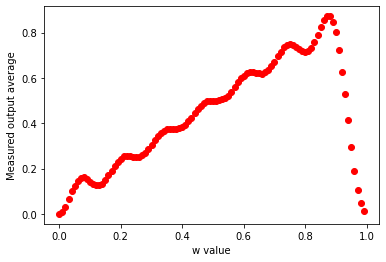

0.75


In [122]:
!pip install qiskit
!pip install qiskit-terra[visualization]
%matplotlib inline
import numpy, numpy.random, scipy, scipy.linalg, math
import matplotlib.pyplot as plt
from qiskit import(QuantumCircuit, execute, Aer)
from qiskit.visualization import plot_histogram
pi = math.pi
simulator = Aer.get_backend('qasm_simulator')
w1 = .5
printed = False
reps = 10000

def perform_circuit(w):
  global printed, simulator, pi, reps
  # Initialize Circuit
  circuit = QuantumCircuit(4, 3)
  # Prepare initial states to |+>
  circuit.h(0)
  circuit.h(1)
  circuit.h(2)

  # Prepare initial states with U1 gates based on phase w
  circuit.u1(2*pi*4*w, 0)
  circuit.u1(2*pi*2*w, 1)
  circuit.u1(2*pi*w, 2)

  # Separate out sections -- initial state is now prepared
  circuit.barrier(0, 1, 2, 3)

  # Perform quantum phase estimation, least significant bit:
  circuit.h(0)

  # Middle bit: 
  circuit.crz(-2*pi/(4), 0, 1)
  circuit.h(1)

  # Most significant bit
  circuit.crz(-2*pi/(8), 0, 2)
  circuit.crz(-2*pi/(4), 1, 2)
  circuit.h(2)

  # Separate out sections -- phase has been read successfully here
  circuit.barrier(0, 1, 2, 3)

  # Place measurements
  circuit.measure([0, 1, 2], [0, 1, 2])

  # Run job simulation, draw and count (can't draw and plot at the same time, for some reason)
  job = execute(circuit, simulator, shots=reps)
  result = job.result()
  counts = result.get_counts(circuit)
  if(not printed):
    print("Circuit diagram: ")
    print(circuit)
    printed = True
  return counts

def countAverage(counts):
  ss = 0.
  for val in counts:
    vi = int(val, 2)
    v = vi / 8.
    co = counts[val]
    ss = ss + v * co
  return ss/reps

OutputTest = lambda ww: countAverage(perform_circuit(ww))
t = numpy.arange(0., 1., .01)
t0 = numpy.array(list(map(OutputTest, t)))
plt.plot(t, t0, 'ro')
plt.xlabel('w value')
plt.ylabel('Measured output average')
plt.show()

print(OutputTest(.75))